In [ ]:
# this version will now try to integrate the previously derived data
# the weights will be entered by hand in the section called weights - ideally this could come
# from a text configuration file to be edited separately

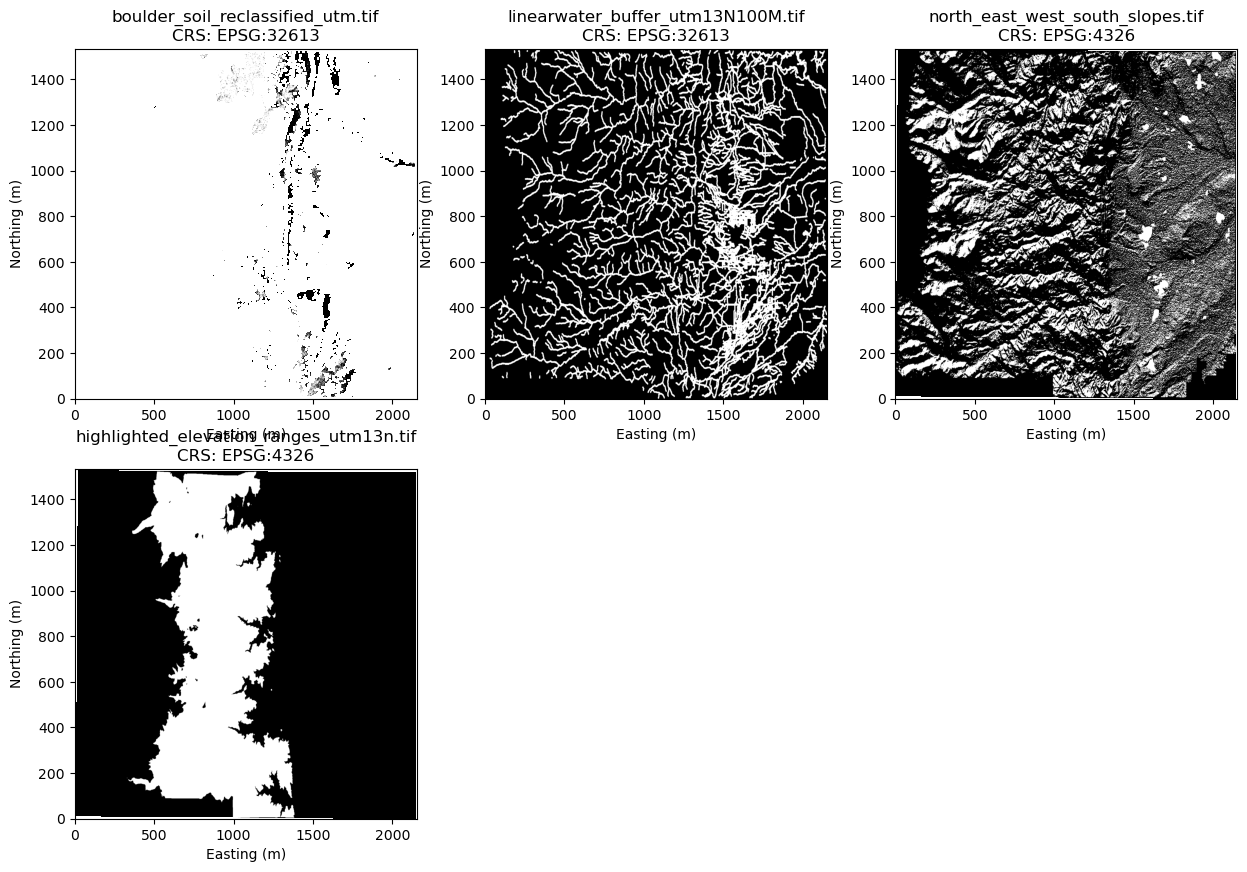

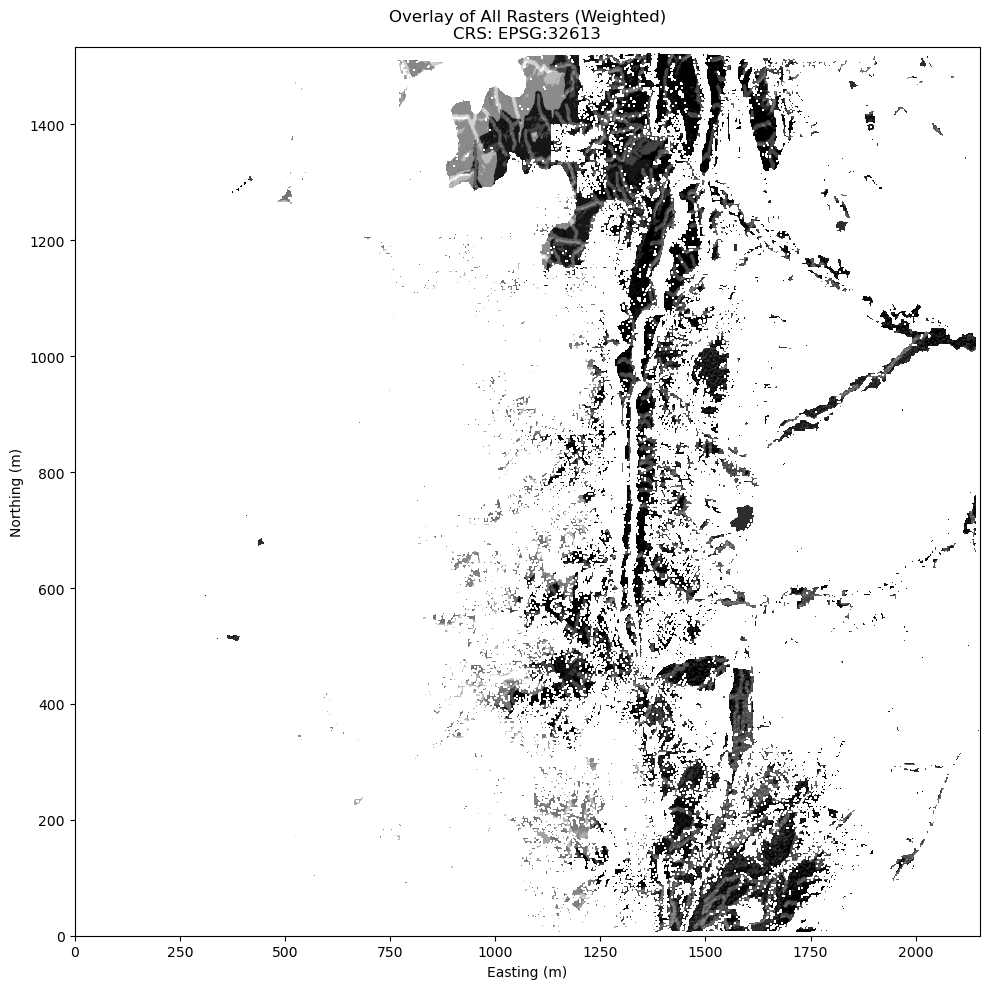

Weighted overlay saved to weighted_overlay.tif


In [2]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import rasterio.crs as crs
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Define file names and their corresponding weights
files = [
    "boulder_soil_reclassified_utm.tif",
    "linearwater_buffer_utm13N100M.tif",
    "north_east_west_south_slopes.tif",
    "highlighted_elevation_ranges_utm13n.tif"
]

weights = [
    0.1,  # for boulder_soil_reclassified_utm.tif
    0.3,  # for linearwater_buffer_utm13N100M.tif
    0.2,  # for north_east_west_south_slopes.tif
    0.5   # for highlighted_elevation_ranges_utm13n.tif (no weight)
]

# Number of rows and columns in the grid
n_cols = 3
n_rows = -(-len(files) // n_cols)  # Ceiling division to determine rows

# Create a figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.ravel()  # Flatten axes for easy indexing

# Harmonize all rasters to the same CRS and spatial extent
def reproject_to_common_crs(src, common_crs, common_transform, common_width, common_height):
    dest = np.zeros((common_height, common_width), dtype=src.read(1).dtype)
    reproject(
        source=rasterio.band(src, 1),
        destination=dest,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=common_transform,
        dst_crs=common_crs,
        resampling=Resampling.nearest
    )
    return dest

# Determine the common CRS and spatial extent
common_crs = "EPSG:32613"  # UTM Zone 13N
common_transform = None
common_width, common_height = None, None

with rasterio.open(files[0]) as ref_src:
    common_transform, common_width, common_height = calculate_default_transform(
        ref_src.crs, common_crs, ref_src.width, ref_src.height, *ref_src.bounds
    )

# Loop through each file and display it
harmonized_data = []
for i, file in enumerate(files):
    try:
        with rasterio.open(file) as src:
            # Reproject to common CRS and extent
            reprojected_data = reproject_to_common_crs(src, common_crs, common_transform, common_width, common_height)

            # Mask invalid data (e.g., no-data values)
            reprojected_data = np.ma.masked_equal(reprojected_data, src.nodata)

            # Scale data to range 0 to 1
            data_min = reprojected_data.min()
            data_max = reprojected_data.max()
            scaled_data = (reprojected_data - data_min) / (data_max - data_min)

            # Store harmonized data for overlay
            harmonized_data.append(scaled_data)

            # Display the raster on the corresponding subplot
            axes[i].imshow(scaled_data, cmap='gray', extent=(0, common_width, 0, common_height), aspect='auto')

            # Set the title with CRS information
            crs_info = src.crs.to_string() if src.crs else "Unknown CRS"
            axes[i].set_title(f"{os.path.basename(file)}\nCRS: {crs_info}")

            # Set UTM Zone 13N axes
            axes[i].set_xlabel("Easting (m)")
            axes[i].set_ylabel("Northing (m)")
    except Exception as e:
        # If there's an error, show it in the plot title
        axes[i].text(0.5, 0.5, f"Error\n{e}", fontsize=10, ha='center', transform=axes[i].transAxes)
        axes[i].set_title(os.path.basename(file))
        axes[i].axis('off')

# Turn off any unused axes
for j in range(len(files), len(axes)):
    axes[j].axis('off')

# Overlay all harmonized data with the weights
fig_overlay, ax_overlay = plt.subplots(figsize=(10, 10))

# Weighted sum of the rasters
combined_data = np.zeros_like(harmonized_data[0])  # Initialize with the same shape as the first raster
for i, data in enumerate(harmonized_data):
    combined_data += data * weights[i]  # Multiply each raster by its weight

# Normalize the combined data to be in the range [0, 1]
combined_data_min = combined_data.min()
combined_data_max = combined_data.max()
combined_data = (combined_data - combined_data_min) / (combined_data_max - combined_data_min)

# Display the combined weighted raster
ax_overlay.imshow(combined_data, cmap='gray', extent=(0, common_width, 0, common_height), aspect='auto')
ax_overlay.set_title("Overlay of All Rasters (Weighted)\nCRS: EPSG:32613")
ax_overlay.set_xlabel("Easting (m)")
ax_overlay.set_ylabel("Northing (m)")

plt.tight_layout()
plt.show()

# Define the output file name
output_file = "weighted_overlay.tif"

# Save the weighted overlay to a GeoTIFF file
with rasterio.open(
    output_file,
    "w",
    driver="GTiff",
    height=combined_data.shape[0],
    width=combined_data.shape[1],
    count=1,
    dtype=combined_data.dtype.name,
    crs=common_crs,
    transform=common_transform
) as dst:
    # Write the normalized weighted overlay data
    dst.write(combined_data.filled(0), 1)  # Use `.filled(0)` if masked values exist

print(f"Weighted overlay saved to {output_file}")


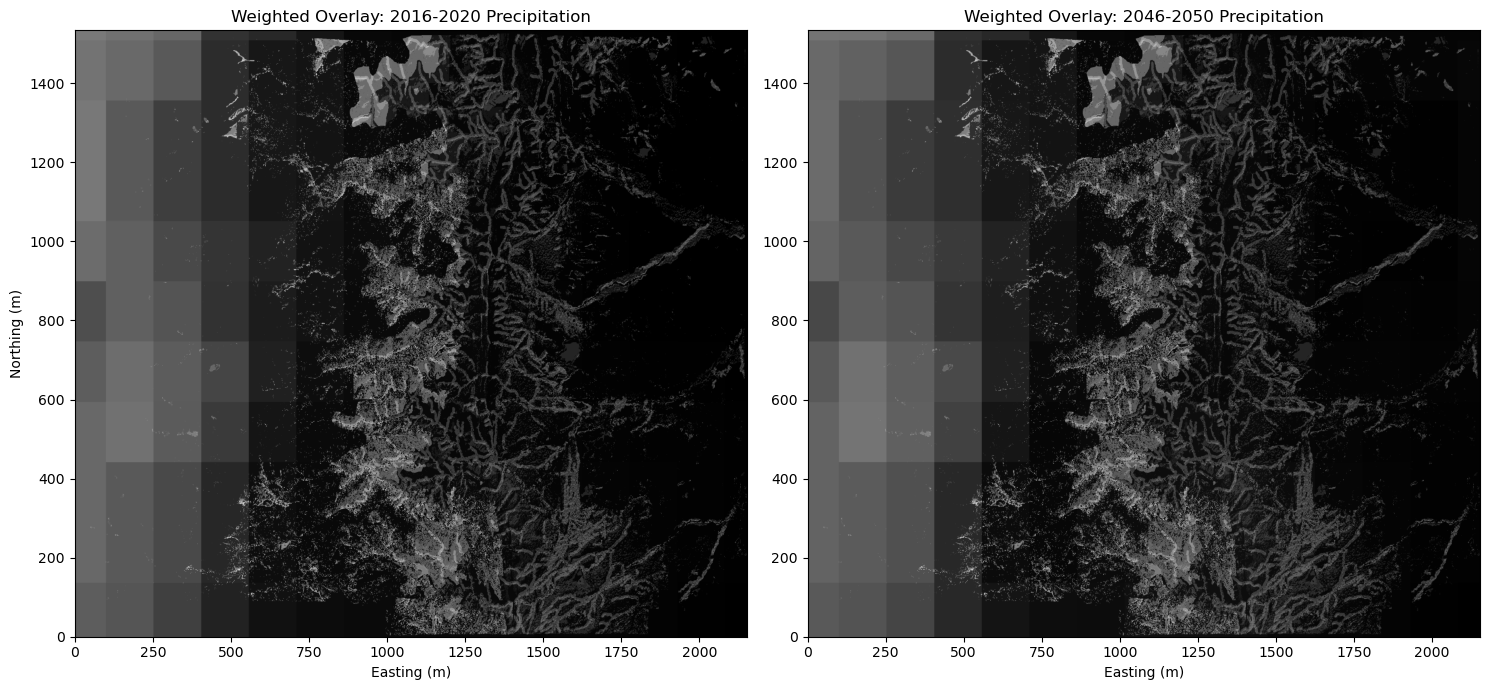

Weighted overlay with 2016-2020 precipitation saved to weighted_overlay_2016_2020.tif
Weighted overlay with 2046-2050 precipitation saved to weighted_overlay_2046_2050.tif


In [3]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Helper function to normalize raster data to the range [0, 1]
def normalize_raster(data):
    data_min = np.min(data)
    data_max = np.max(data)
    return (data - data_min) / (data_max - data_min)

# Load and normalize a raster file to the common CRS and extent
def load_and_normalize_raster(file, common_crs, common_transform, common_width, common_height):
    with rasterio.open(file) as src:
        # Reproject to common CRS and extent
        dest = np.zeros((common_height, common_width), dtype=src.read(1).dtype)
        reproject(
            source=rasterio.band(src, 1),
            destination=dest,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=common_transform,
            dst_crs=common_crs,
            resampling=Resampling.nearest
        )
        # Normalize data to range [0, 1]
        return normalize_raster(np.ma.masked_equal(dest, src.nodata))

# Define file paths
weighted_overlay_file = "weighted_overlay.tif"
precip_2016_2020_file = "boulder_precipitation_utm13_2016_2020.tif"
precip_2046_2050_file = "boulder_precipitation_utm13_2046_2050.tif"

# Load the base weighted overlay
with rasterio.open(weighted_overlay_file) as ref_src:
    # Determine common CRS and extent
    common_crs = ref_src.crs
    common_transform = ref_src.transform
    common_width = ref_src.width
    common_height = ref_src.height

    # Read and normalize the weighted overlay
    base_weighted_overlay = normalize_raster(ref_src.read(1))

# Load and normalize the precipitation datasets
precip_2016_2020 = load_and_normalize_raster(precip_2016_2020_file, common_crs, common_transform, common_width, common_height)
precip_2046_2050 = load_and_normalize_raster(precip_2046_2050_file, common_crs, common_transform, common_width, common_height)

# Create the two additional weighted overlays
weighted_overlay_2016_2020 = (0.6 * base_weighted_overlay) + (0.4 * precip_2016_2020)
weighted_overlay_2046_2050 = (0.6 * base_weighted_overlay) + (0.4 * precip_2046_2050)

# Normalize the results
weighted_overlay_2016_2020 = normalize_raster(weighted_overlay_2016_2020)
weighted_overlay_2046_2050 = normalize_raster(weighted_overlay_2046_2050)

# Define output file names
output_file_2016_2020 = "weighted_overlay_2016_2020.tif"
output_file_2046_2050 = "weighted_overlay_2046_2050.tif"

# Save the weighted overlays to GeoTIFF files
def save_raster(data, output_file):
    with rasterio.open(
        output_file,
        "w",
        driver="GTiff",
        height=data.shape[0],
        width=data.shape[1],
        count=1,
        dtype=data.dtype.name,
        crs=common_crs,
        transform=common_transform
    ) as dst:
        dst.write(data, 1)

save_raster(weighted_overlay_2016_2020, output_file_2016_2020)
save_raster(weighted_overlay_2046_2050, output_file_2046_2050)

# Display the weighted overlays side by side
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(weighted_overlay_2016_2020, cmap='gray', extent=(0, common_width, 0, common_height), aspect='auto')
axes[0].set_title("Weighted Overlay: 2016-2020 Precipitation")
axes[0].set_xlabel("Easting (m)")
axes[0].set_ylabel("Northing (m)")

axes[1].imshow(weighted_overlay_2046_2050, cmap='gray', extent=(0, common_width, 0, common_height), aspect='auto')
axes[1].set_title("Weighted Overlay: 2046-2050 Precipitation")
axes[1].set_xlabel("Easting (m)")

plt.tight_layout()
plt.show()

print(f"Weighted overlay with 2016-2020 precipitation saved to {output_file_2016_2020}")
print(f"Weighted overlay with 2046-2050 precipitation saved to {output_file_2046_2050}")
